# Demo Run

In [1]:
# %load_ext autoreload
# %autoreload 2
# # # this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np

sys.path.append(str(Path(os.getcwd()).resolve().parents[0]))

import tardis

local_run = False
if local_run:
    tardis.config = tardis.config_local
else:
    tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [4]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_subset_age_4.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata

AnnData object with n_obs × n_vars = 178608 × 4096
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes'
    uns: 'rank_genes_groups'

In [5]:
warmup_epoch_range = [10, 30]
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 400

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = True,
                weight = 100,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = 10, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=30, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=1000,
    train_size=0.8,
    batch_size=512,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=True,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-6,
        # optimizer="AdamW"
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key="concatenated_integration_covariates",
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(adata, **model_params)
vae.train(**train_params)

CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8800, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-3acbc457-82bc-59c2-a4db-9fd26324b7db,MIG-4c9f6b87-24d0-56dc-8d0c-4b5af0ebfa7b]
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-p

Epoch 1/1000:   0%|                                                                                                            | 0/1000 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractiveminibatchgenerator.py:63: UserWarning: Possible group definition indices are calculating for `age` for `training` set.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractiveminibatchgenerator.py:63: UserWarning: Number of elements in each group for `age` in `training` set: 17249,19780,15556,7144,10747,23514,5584,23234,14935,5144
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractiveminibatchgenerator.py:63: UserWarning: Possible group definition indices are calculating for `age` for `validation` set.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractiveminibatchgenerator.py:63: UserWarning: Number of elements in each group for `age` in `validation` set: 4293,5075,3887,1830,2800,5858,1388,5553,3722,1315
  possible_i

Epoch 34/1000:   3%|▋                   | 33/1000 [06:44<3:10:03, 11.79s/it, v_num=1, total_loss_train=274, kl_local_train=135, tardis_age_0_train=25.4]

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [6]:
vae.history.keys()

dict_keys(['lr-Adam', 'kl_weight', 'total_loss_validation', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'tardis_age_0_validation', 'tardis_age_1_validation', 'tardis_mean_validation', 'tardis_age_0_weighted_validation', 'tardis_age_1_weighted_validation', 'tardis_mean_weighted_validation', 'kl_local_weighted_validation', 'total_loss_train', 'elbo_train', 'reconstruction_loss_train', 'kl_global_train', 'kl_local_train', 'tardis_age_0_train', 'tardis_age_1_train', 'tardis_mean_train', 'tardis_age_0_weighted_train', 'tardis_age_1_weighted_train', 'tardis_mean_weighted_train', 'kl_local_weighted_train'])

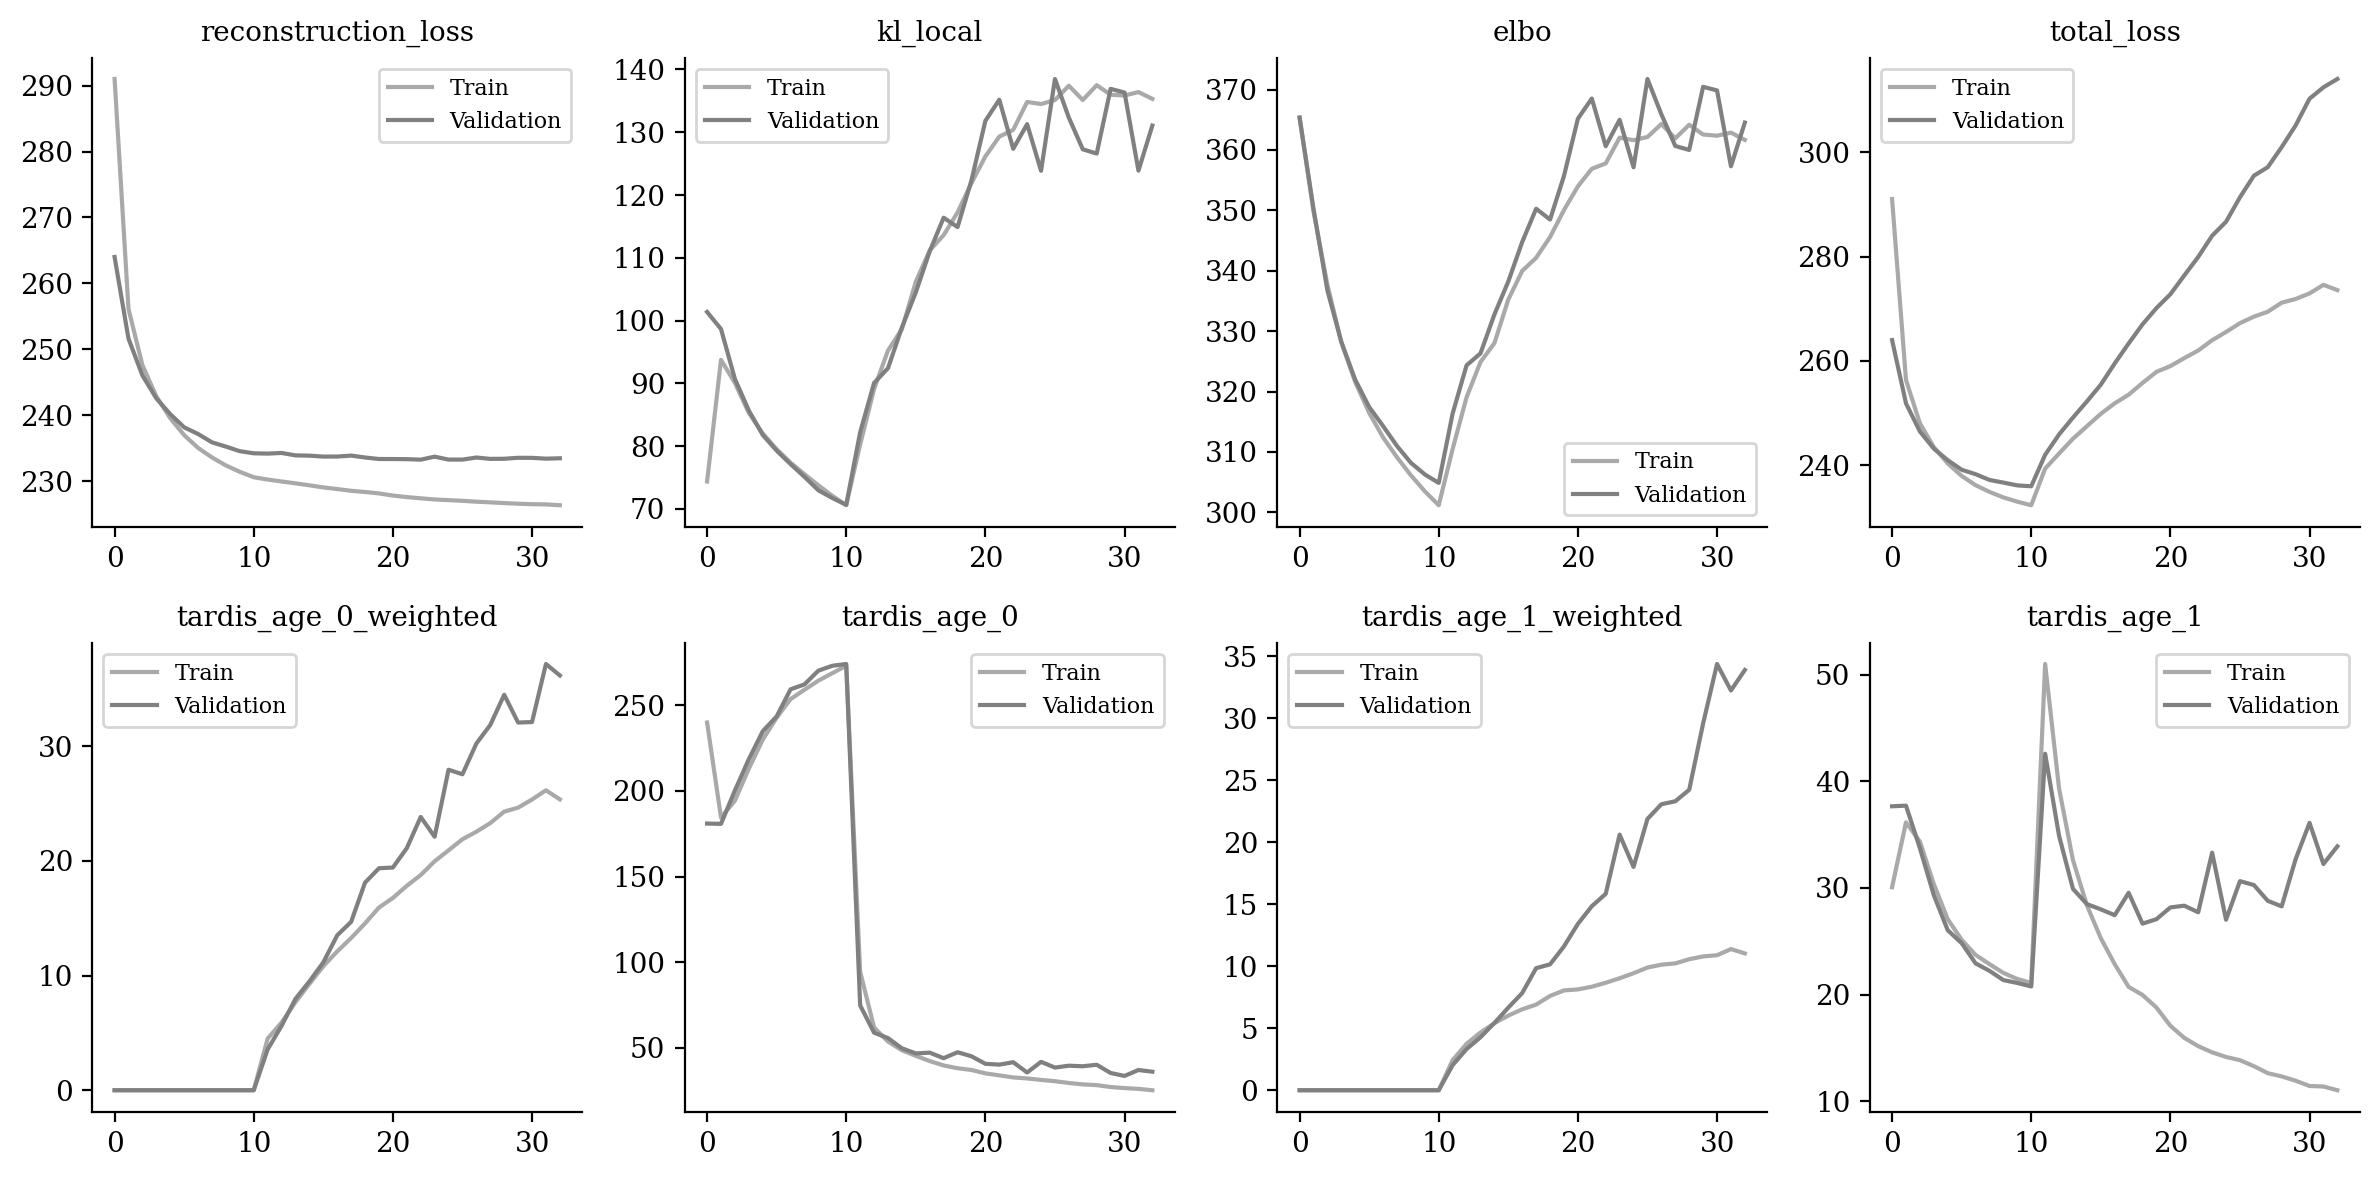

In [7]:
vae.plot_training_history(
    ignore_first=0, 
    n_col=4,
    metrics_name=[
        "reconstruction_loss", "kl_local", "elbo", "total_loss",
        #
        "tardis_age_0_weighted", 
        "tardis_age_0",
        "tardis_age_1_weighted", 
        "tardis_age_1",
    ]
)

In [8]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices

[0, 1, 2, 3, 4, 5, 6, 7]

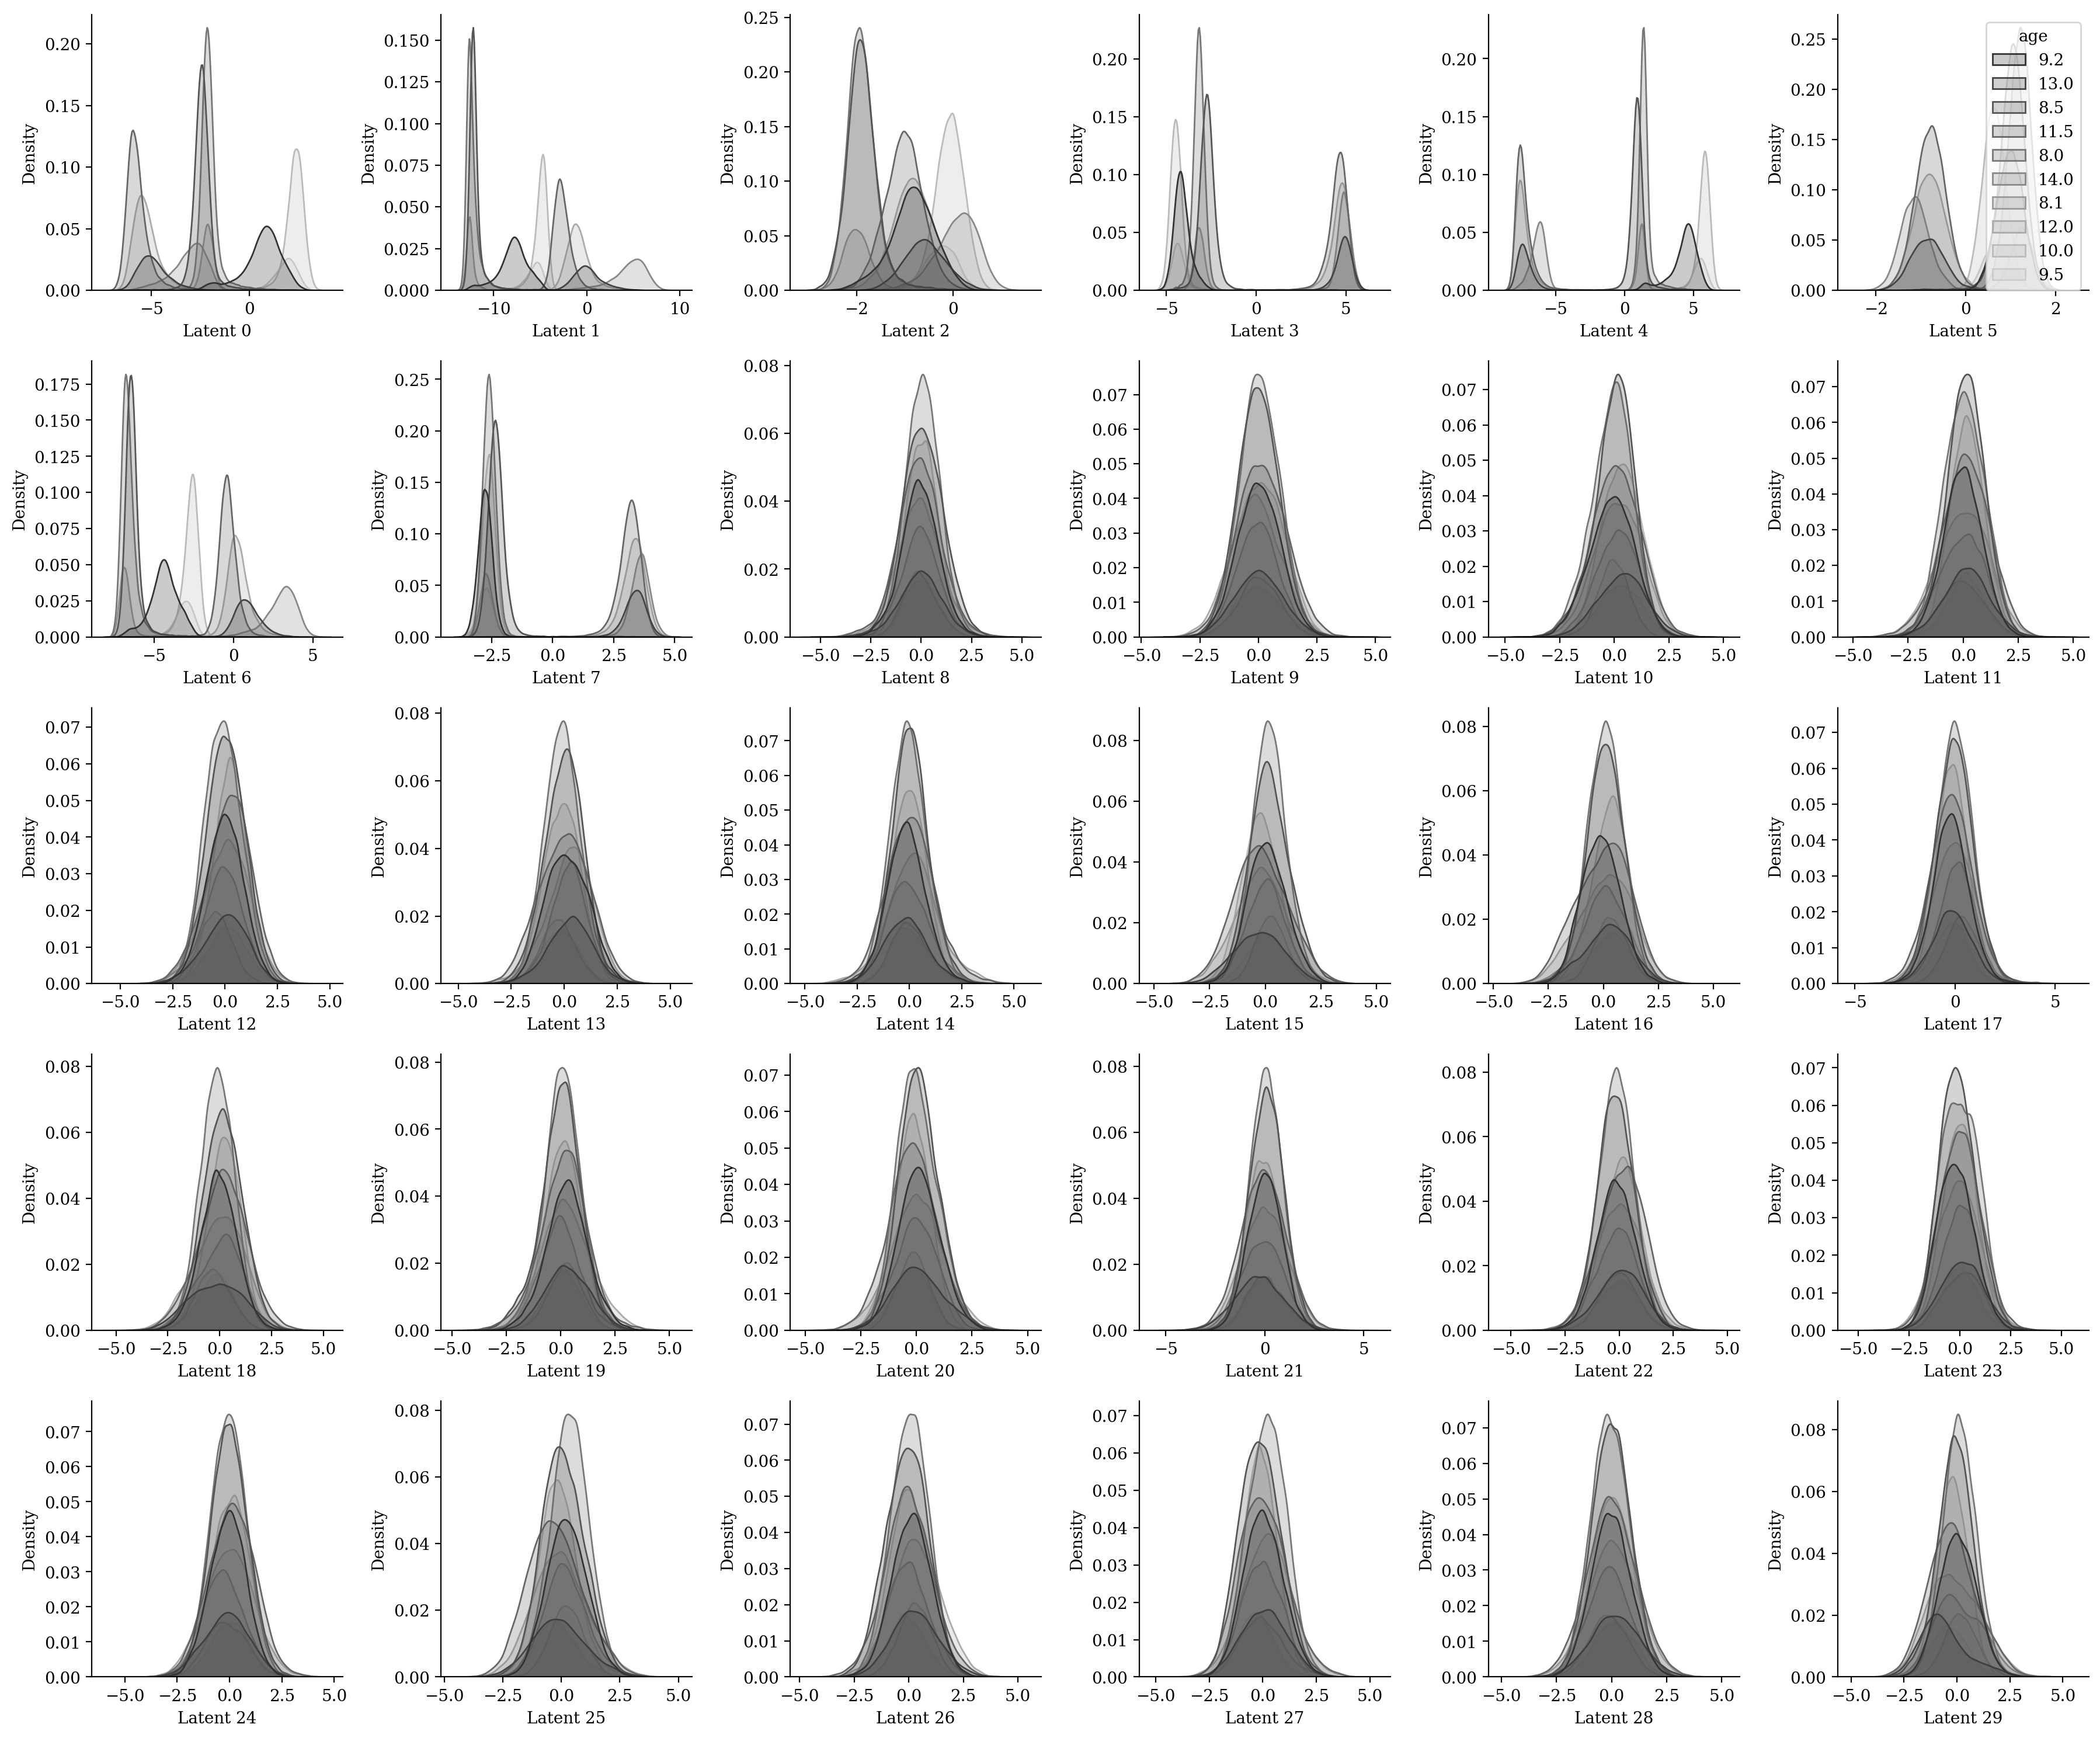

In [9]:
vae.plot_latent_kde(
    adata_obs=adata.obs,
    target_obs_key="age",
    latent_representation=vae.get_latent_representation(),
    latent_dim_of_interest=None
)

# Playground

In [10]:
vae.get_reconstruction_r2(batch_size=512, indices=vae.train_indices)

0.7172764618192712

In [11]:
vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=512, indices=vae.train_indices)

0.00019706083006492442

In [12]:
vae.get_reconstruction_r2(batch_size=512, indices=vae.validation_indices)

0.6658929844089899

In [13]:
vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=512, indices=vae.validation_indices)

0.16225673254791242

In [ ]:
X = vae.get_latent_representation()
# Construct a k-nearest neighbor graph
k = 30  # Number of neighbors
A = kneighbors_graph(X, k, mode='distance', include_self=False)
graph = nx.from_numpy_array(A.A)
min_age = np.min(adata.obs["age"].astype(float))
# re-run couple of times to make sure
root_node = np.random.choice(np.where(adata.obs["age"] == str(min_age))[0])  
# Root the graph (choose a node based on some criteria)
# Compute shortest paths from root to all other nodes
pseudotime = nx.single_source_dijkstra_path_length(graph, root_node)

# Visualization

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
latent.obs["pseudotime"] = [pseudotime[i] for i in range(len(adata))]
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "pseudotime", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        color_map="inferno",
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("age").unreserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
latent.obs["pseudotime"] = [pseudotime[i] for i in range(len(adata))]
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "pseudotime", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        color_map="inferno",
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

In [ ]:
from tardis._disentenglementtargetmanager import DisentenglementTargetManager
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
latent.obs["pseudotime"] = [pseudotime[i] for i in range(len(adata))]
display(latent.shape)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "pseudotime", "cell_type", "concatenated_integration_covariates"], 
        ncols=2,
        color_map="inferno",
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )

del latent
gc.collect();

# Cell types

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
latent.obs["pseudotime"] = [pseudotime[i] for i in range(len(adata))]
for cell_type in latent.obs["cell_type"].unique():
    _latent = latent[latent.obs["cell_type"] == cell_type].copy()
    sc.pp.neighbors(_latent, n_neighbors = 30)
    sc.tl.umap(_latent)    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            _latent, 
            color=["age", "pseudotime", "concatenated_integration_covariates"], 
            ncols=3,
            frameon=False,
            title=cell_type,
            legend_fontsize="xx-small",
            color_map="inferno",
        )
    del _latent
    gc.collect();

del latent
gc.collect();

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
latent.obs["pseudotime"] = [pseudotime[i] for i in range(len(adata))]
for cell_type in latent.obs["cell_type"].unique():
    _latent = latent[latent.obs["cell_type"] == cell_type].copy()
    sc.pp.neighbors(_latent, n_neighbors = 30)
    sc.tl.umap(_latent)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            _latent, 
            color=["age", "pseudotime", "concatenated_integration_covariates"], 
            ncols=3,
            frameon=False,
            title=cell_type,
            legend_fontsize="xx-small",
            color_map="inferno",
        )
    del _latent
    gc.collect();
    
del latent
gc.collect();

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentenglementTargetManager.configurations.unreserved_latent_indices], obs=adata.obs.copy())
latent.obs["pseudotime"] = [pseudotime[i] for i in range(len(adata))]
for cell_type in latent.obs["cell_type"].unique():
    _latent = latent[latent.obs["cell_type"] == cell_type].copy()
    sc.pp.neighbors(_latent, n_neighbors = 30)
    sc.tl.umap(_latent)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            _latent, 
            color=["age", "pseudotime", "concatenated_integration_covariates"], 
            ncols=3,
            frameon=False,
            title=cell_type,
            legend_fontsize="xx-small",
            color_map="inferno",
        )
    del _latent
    gc.collect();
    
del latent
gc.collect();